# Project: user's heading and speed estimation with smartphon IMU sensors
This is created by Hsiu-Wen Chang Joly, Date: 01, Feb., 2023

* Background: Pedestrian Dead Reckoning (PDR) uses inertial measurement units (IMUs) and combines displacement (velocity) and orientation estimates to determine a position. The estimation of the displacement(or velocity) is still challenging, as the integration of noisy acceleration and angular speed signals over a long period oftime causes large drifts. Classic approaches to estimate the displacement optimize for specific applications,sensor positions, and types of movement and require extensive parameter tuning.

Classical PDR: the 2D position of the new step $$p(k) = [x,y] = [d_k*cos(\theta), d(k)*sin(\theta)]+p(k-1)$$ where d_k is the k-th step length, theta_k is the heading of human body, p(k-1) is the position of last step.

Simiplifed way: if we knows the average of heading $\hat{\theta}$ of the user from $t_{k}$ to $t_{k+n}$ and its corresponding average speed $\hat{v}$, then the position of the user at $t_k$ is simply the integration
$$p(k) = [\hat{v}*dt*cos(\hat{\theta}), \hat{v}*dtsin(\hat{\theta})]+p(k-1)$$

* task: use one seconds of IMU data (gyro reading, accelerometer readings) from smartphone to predict the heading and speed ($\hat{\theta}$,$\hat{v}$). Generate position at 1 Hz rate (However, it doesn't mean you have to generate training sample exactly the same way)

* candidate architectures: CNN, LSTN

* Data description: 
Each folder represents 1 trajectory with random user's behavior (phone in pocket, hold it and swing arm, texting).
Inside each folder, *.hdf5 contains processed IMU data (time sychronization, bias removal, levelling)

We will use ground truth generated by Google tangle


Advance option: create your own data by using your phone. Do finetuning with the following step
1) read read http://sensorlog.berndthomas.net/ to have the format of file. 
2) leveled accelerationa and gyroscope using roll and pitch.
3) create ground-truth (you can measure the walking distance and walked in a building with known indoor map. Manually key in 2D velocity)
4) create your dataloader
5) Start training!


***What to submit***

The expected content of the this project's report should contains:
1. Basic description of the background
2. performance of ML with different data augmentation, architecture, loss function, time comsumption
3. Albation study.


## Step 1: Data loading and formatting training and test data

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import random
import copy
import time

import os
from os import path as osp
from tensorboardX import SummaryWriter
import json
from matplotlib.ticker import MultipleLocator

### Introduction to h5py file
HDF5 (Hierarchical Data Format 5) is an open-source file which stores data in a hierarchical structure. So it enables us to quickely access a particular part of the file rather than the whole file. This is very useful when we do training.
### Pricinple knoweldge of data processing
1. Unix time is a way of representing a timestamp by representing the time as the number of seconds since January 1st, 1970 at 00:00:00 UTC
2. Unit for gyro reading can be deg/s or rad/s. 
3. Acceleration can have be with/without gravity

In [3]:
import h5py
import json


### Understand the data format from Ronin data benchmark

1. Download the smaller size of preprocessed IMU data at [link](https://cloud.minesparis.psl.eu/index.php/s/CzZoYiMojbZ3nUV)
and change the data_path to the this folder
2. You can find three txt files that help you seperates the data into training, validation and test

*The IMU data is sampled at 200 Hz. Since the first groundtruth label corresponding to first 200 sample of IMU window, you will find the length of ground truth has 200 sample less than IMU data. 

In [4]:
import quaternion
# Dowdload dataset from offical websit, uncompressed
#print(os.getcwd())

# Here we try to see some of the datasets
data_path = 'ronin_data_simple'
data_list = ['a000_1','a006_2','a039_2']

# Read meta data
with open(os.path.join(data_path, 'config.json')) as f:
    info = json.load(f)

#print(f'feature_dim:{info['feature_dim']})
print(info)
# Read provided data
features_all, targets_all, aux_all = [], [], []
for i in range(len(data_list)):
    with h5py.File(os.path.join(data_path, data_list[i] + '.hdf5')) as f:
        feat = np.copy(f['feature'])
        targ = np.copy(f['target'])
        aux = np.copy(f['aux']) #timetage(ts), groundtruth orientation , ground-truth position(x,y,h)
        
    features_all.append(feat)
    targets_all.append(targ)
    aux_all.append(aux)

{'feature_dim': 6, 'target_dim': 2, 'aux_dim': 8, 'grv_only': 'False'}


## Step 2: Display some of the timeseries (Sanity check)

In [8]:
# Display data
## Plot the position from Tangle phone
traj_ID = 1
speed = np.linalg.norm(targets_all[traj_ID], axis=1)
ts = aux_all[traj_ID][:,0]-aux_all[traj_ID][0,0]
ts_imu =ts[200:]-ts[0]
heading = np.arctan(targets_all[traj_ID][:,1],targets_all[traj_ID][:,0])

acce = features_all[traj_ID][:,:3]
gyro = features_all[traj_ID][:,3:]

print('IMU ts (samples unit):',len(ts))
print('Ground truth speed size',len(speed))
print('round truth heading size',len(heading))
print('acce:',len(acce))
print('gyro:',len(gyro))

IMU ts (samples unit): 167570
Ground truth speed size 167370
round truth heading size 167370
acce: 167570
gyro: 167570


No handles with labels found to put in legend.


Text(0.5, 0, 's')

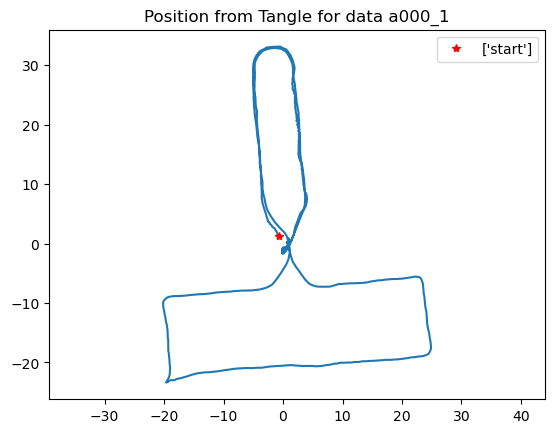

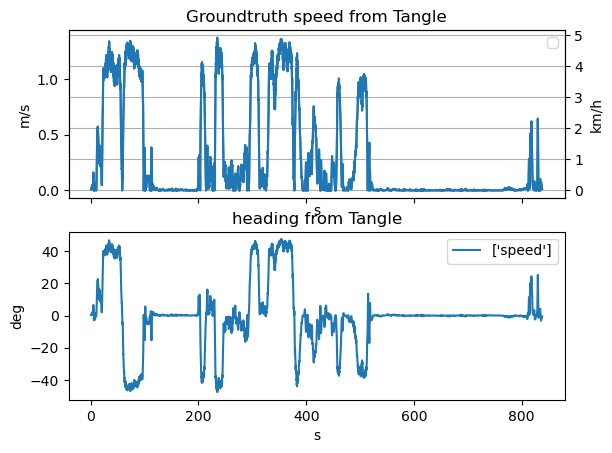

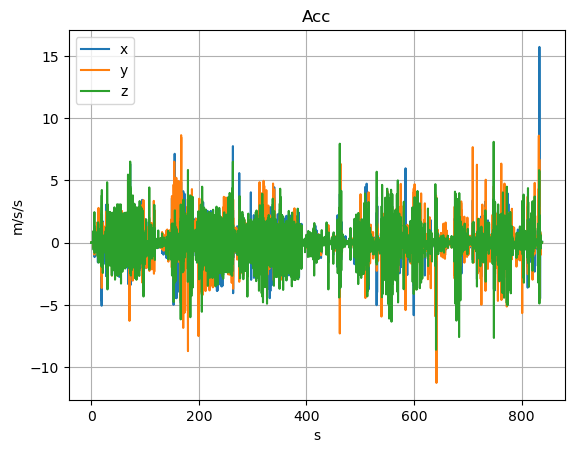

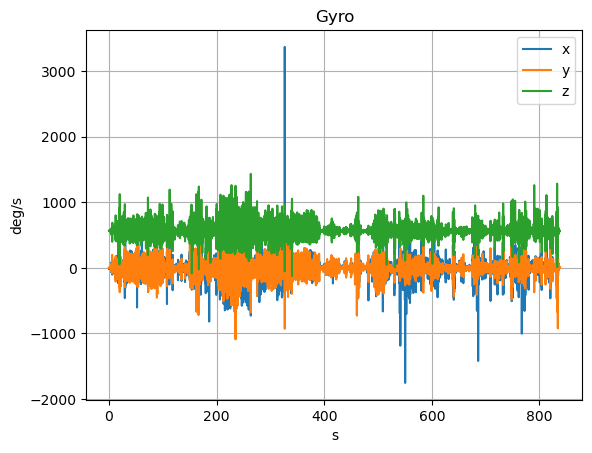

In [13]:
plt.figure()
plt.title(f'Position from Tangle for data {data_list[0]}')
plt.plot(aux_all[traj_ID][:,5],aux_all[traj_ID][:,6]),plt.grid()
plt.plot(aux_all[traj_ID][0,5],aux_all[traj_ID][0,6],'r*',label=['start']),plt.grid()
plt.axis('equal'), plt.legend()


## Plot speed estimated by Tangle phone
fig, ax=plt.subplots(2,1,sharex='col')
ax[0].set_title('Groundtruth speed from Tangle')
ax[0].plot(ts_gt, speed)
ax[0].set_ylabel('m/s')
ax[0].set_xlabel('s')
ax[0].legend()
ax2 = ax[0].twinx()
ax2.plot(ts_gt, speed*3600/1000)
ax2.set_ylabel('km/h')
ax2.grid()
ax[1].set_title('heading from Tangle')
ax[1].plot(ts_gt, heading*180/np.pi,label=['speed'])
ax[1].set_ylabel('deg')
ax[1].set_xlabel('s')
ax[1].legend()

## Plot the acceleration from IMU
plt.figure()
plt.title('Acc')
plt.plot(ts,acce, label=('x','y','z')),plt.grid()
plt.legend()
plt.ylabel('m/s/s')
plt.xlabel('s')

## Plot the gyro from IMU
plt.figure()
plt.title('Gyro')
plt.plot(ts,gyro*180/np.pi, label=('x','y','z')),plt.grid()
plt.ylabel('deg/s')
plt.legend()
plt.xlabel('s')

## Step 3: Prepare your dataset and dataloader

In [ ]:
from torch.utils.data import Dataset

class mydataset(Dataset):
    feature_dim = 6 # 3 acc + 3 gyro
    target_dim = 2 # speed, heading
    aux_dim = 8 # 8 extra information

    def __init__(self,root_dir, data_list, step_size=10, window_size=200,random_shift=0, shuffle_fea=True):
        super().__init__()
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.aux_dim = aux_dim
        self.window_size = window_size
        self.step_size = step_size
        self.random_shift = random_shift
        #self.transform = transform # data augmentation by rotate IMU z-axis randomly
        self.interval = window_size
        self.shuffle_fea = shuffle_fea
        self.data_path = [osp.join(root_dir, data) for data in data_list]
        self.index_map = []
        self.ts, self.orientations, self.gt_pos = [], [], []

        if data_path is not None:
            self.load(data_path)

    def load(self, data_path):
        for i in range(len(data_list)):
            with h5py.File(os.path.join(data_path, data_list[i] + '.hdf5')) as f:
                feat = np.copy(f['feature'])
                targ = np.copy(f['target'])
                aux = np.copy(f['aux']) #timetage(ts), groundtruth orientation , ground-truth position(x,y,h)
                
            self.features.append(feat)
            self.targets.append(targ)
            
        for i in range(len(data_list)):
            self.ts.append(aux[i][:, 0])
            self.orientations.append(aux[i][:, 1:5])
            self.gt_pos.append(aux[i][:, -3:])
            self.index_map += [[i, j] for j in range(0, self.targets[i].shape[0], step_size)]

        if self.shuffle_fea:
            random.shuffle(self.index_map)

    def __getitem__(self, item):
        seq_id, frame_id = self.index_map[item][0], self.index_map[item][1]
        if self.random_shift > 0:
            frame_id += random.randrange(-self.random_shift, self.random_shift)
            frame_id = max(self.window_size, min(frame_id, self.targets[seq_id].shape[0] - 1))

        feat = self.features[seq_id][frame_id:frame_id + self.window_size]
        targ = self.targets[seq_id][frame_id]

        #if self.transform is not None:
        #    feat, targ = self.transform(feat, targ)

        return feat.astype(np.float32).T, targ.astype(np.float32), seq_id, frame_id
    
    def __len__(self):
        return len(self.index_map)



## Step 4: Create your NN to train!

Recommended NN candidates: RestNet18, LSTM
Questions that you will need to think:
(1) heading and speed have two different units. The design of the loss function is therefore, important to balance the behavior of heading performance and speed performance.


### Advanced option: generated your own dataset by sensorlog


In [ ]:
def generate_csv2cached(filename,out_path):
   
    # Reading csv
    df = pd.read_csv(filename, sep=",",header=0)
    if 'locationTimestamp_since1970(s)' not in df.keys():
        print(f'wrong csv formate: {filename}')
        return

    unix_timestamps=df['locationTimestamp_since1970(s)'].to_numpy().astype('float')
    timestamps=df['motionTimestamp_sinceReboot(s)'].to_numpy().astype('float')
    timestamps=timestamps-timestamps[0]
    print(f'Average sampling rate:{1/np.mean(np.diff(timestamps))}')

    speed_data=df['locationSpeed(m/s)'].to_numpy().astype('float')*3.6 #unit in km/h
    acc_data=df[['motionUserAccelerationX(G)','motionUserAccelerationY(G)','motionUserAccelerationZ(G)']].to_numpy().astype('float')*9.8+df[['motionGravityX(G)','motionGravityY(G)','motionGravityZ(G)']].to_numpy().astype('float')*9.8
    if 'accelerometerAccelerationX(G)' in df.keys():
        acc_data=df[['accelerometerAccelerationX(G)','accelerometerAccelerationY(G)','accelerometerAccelerationZ(G)']].to_numpy().astype('float')*9.8
    acc_data=-acc_data

    gyr_data=df[['motionRotationRateX(rad/s)','motionRotationRateY(rad/s)','motionRotationRateZ(rad/s)']].to_numpy().astype('float')

    mag_data=df[['motionMagneticFieldX(µT)','motionMagneticFieldY(µT)','motionMagneticFieldZ(µT)']].to_numpy().astype('float')
    ea_data=df[['motionRoll(rad)','motionPitch(rad)','motionYaw(rad)']].to_numpy().astype('float')
    q_data=quaternion.as_quat_array(df[['motionQuaternionW(R)','motionQuaternionX(R)','motionQuaternionY(R)','motionQuaternionZ(R)']].to_numpy().astype('float'))
    pos_data=df[['locationLatitude(WGS84)','locationLongitude(WGS84)','locationAltitude(m)']].to_numpy().astype('float')
    grav_data = df[['motionGravityX(G)','motionGravityY(G)','motionGravityZ(G)']].to_numpy().astype('float')
    index=np.shape(df.to_numpy())[0]

    # Resampling
    timestamps200=np.arange(timestamps[0],timestamps[-1],1/200)
    acc_data200=np.array([np.interp(timestamps200, timestamps, acc_data[:,i]) for i in range(acc_data.shape[1])]).T
    gyr_data200=np.array([np.interp(timestamps200, timestamps, gyr_data[:,i]) for i in range(gyr_data.shape[1])]).T
    mag_data200=np.array([np.interp(timestamps200, timestamps, mag_data[:,i]) for i in range(mag_data.shape[1])]).T
    pos_data200=np.array([np.interp(timestamps200, timestamps, pos_data[:,i]) for i in range(pos_data.shape[1])]).T
    grav_data200=np.array([np.interp(timestamps200, timestamps, grav_data[:,i]) for i in range(grav_data.shape[1])]).T
    unix_timestamps200 = np.interp(timestamps200, timestamps, unix_timestamps) 
    manu_speed200 = np.interp(timestamps200, timestamps, manu_speed[:,0])
    q_data200=[]   
    ea_data200 =[] 
    count = 0
    ts,te = timestamps[0],timestamps[1]
    for i, t_tau in enumerate(timestamps200):
        if ts > t_tau:
            count += 1
            ts = timestamps[count]
            te = timestamps[min(count+1, len(timestamps))]

        if ts == t_tau or ts == te:
            q_data200.append(quaternion.as_float_array(q_data[count]))
            ea_data200.append(quaternion.as_euler_angles(q_data[count]))
        else:
            new_q = quaternion.slerp(q_data[count], q_data[count+1], ts,te,t_tau )
            q_data200.append(quaternion.as_float_array(new_q) )
            ea_data200.append(quaternion.as_euler_angles(new_q)) 
    ea_data200=np.array(ea_data200)
    
    #TODO finalize the format of folders so this function can generate meta by itself. Currently we need to write meta data by ourself
    f_name = filename.split('/')[-1] 
    meta_info = {'type': 'unannotated',
                'length': f'{timestamps[-1]-timestamps[0]}',
                'date': f'{f_name[8:10]}/{f_name[5:7]}/{f_name[2:4]}',
                'device': filename.split('/')[0],
                'person': person_name,
                'activity': filename.split('/')[1], #TODO: ask to add this naming rule to SOP doc
                'manual_speed':speed_list,
                'imu_reference_time': unix_timestamps[0].tolist(),
    }
    json.dump(meta_info, open(osp.join(out_path, 'info.json'), 'w'))
    
    # resmapling to match 200 HZ for RoNIN networks
    timestamps2=np.arange(timestamps[0],timestamps[-1],1/frequence_ronin)

    with h5py.File(os.path.join(out_path, 'data.hdf5'), 'x') as f:
        #"raw" group contains data as reported by APIs in format 
        # - system_timestamp (nanosecond), API output
        f.create_group('raw/imu')
        f.create_dataset('raw/system_timestamp200',data=unix_timestamps)
        f.create_dataset('raw/imu/gyro',data=gyr_data)
        f.create_dataset('raw/imu/gyro_uncalib',data=gyr_data_uncalib) #TODO
        f.create_dataset('raw/imu/acce',data=acc_data) #TODO
        f.create_dataset('raw/imu/magnet',data=mag_data) #TODO
        f.create_dataset('raw/imu/game_rv',data=ea_data) #TODO: make sure it match the defintion since we switch the roll, pitch, yaw order
        #f.create_dataset('raw/imu/game_rv',data=ea_data) #TODO

        #"synced" group contains time synchronized data from IMU device sampled at 200 Hz
        # - time : System time of IMU device in seconds  
        f.create_group('synced')
        f.create_dataset('synced/time', data=timestamps200)
        f.create_dataset('synced/gyro', data=gyr_data200)
        f.create_dataset('synced/acce', data=acc_data200)
        f.create_dataset('synced/magnet', data=mag_data200)
        f.create_dataset('synced/game_rv', data=ea_data200)
        f.create_dataset('synced/rv', data=ea_data200) #TODO: need to figure the defintion of game rv and rv, currently we use defintion from numpy-quaternion
        f.create_dataset('synced/grav',data=grav_data200)
        f.create_dataset('synced/manu_speed',data=manu_speed200)
        #f.create_dataset('synced/linacce',data=df[].to_numpy().astype('float')) #TODO